In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import fiona
from shapely.geometry import Point, shape
from gisutils import df2shp, project
from pydrograph import Nwis

### instantiate an NWIS object using a polygon shapefile of the study area
* `bbox.shp` is in UTM 83 zone 15 N
* pydrograph will automatically reproject the extent to GCS NAD83 by default (EPSG: 4269), which is the typical GCS used by NWIS. Alternatively, the NAD27 datum can be used (EPSG: 4267) by specifying `datum=NAD27` to the `NWIS()` constructor.

In [2]:
nwis = Nwis(extent='../data/bbox.shp')

reading extent from ../data/bbox.shp...
reprojecting extent from +init=epsg:26915 to +proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs


/Users/aleaf/Documents/GitHub/pydrograph/pydrograph/nwis.py:163: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  g = shape(shp.next()['geometry'])
/Users/aleaf/opt/anaconda3/envs/gis/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


### field measurements inventory table
* fetches inventory tables of all misc field measurements within the polygon

In [3]:
field_sites = nwis.get_siteinfo('field_measurements')

getting site inventory for field_measurements...
url: http://nwis.waterdata.usgs.gov/usa/nwis/measurements?nw_longitude_va=-92.700&nw_latitude_va=46.800&se_longitude_va=-92.600&se_latitude_va=46.700&coordinate_format=decimal_degrees&group_key=NONE&format=sitefile_output&sitefile_output_format=rdb&column_name=site_no&column_name=station_nm&column_name=site_tp_cd&column_name=dec_lat_va&column_name=dec_long_va&column_name=coord_meth_cd&column_name=coord_acy_cd&column_name=coord_datum_cd&column_name=dec_coord_datum_cd&column_name=district_cd&column_name=state_cd&column_name=county_cd&column_name=country_cd&column_name=land_net_ds&column_name=map_nm&column_name=map_scale_fc&column_name=alt_va&column_name=alt_meth_cd&column_name=alt_acy_va&column_name=alt_datum_cd&column_name=huc_cd&column_name=basin_cd&column_name=topo_cd&column_name=inventory_dt&column_name=drain_area_va&column_name=contrib_drain_area_va&column_name=tz_cd&column_name=local_time_fg&column_name=reliability_cd&column_name=pro

### daily values sites inventory table

In [4]:
dv_sites = nwis.get_siteinfo('daily_values')

getting site inventory for daily_values...
url: http://nwis.waterdata.usgs.gov/usa/nwis/dv?referred_module=sw&site_tp_cd=ST&nw_longitude_va=-92.700&nw_latitude_va=46.800&se_longitude_va=-92.600&se_latitude_va=46.700&coordinate_format=decimal_degrees&group_key=NONE&format=sitefile_output&sitefile_output_format=rdb&column_name=site_no&column_name=station_nm&column_name=site_tp_cd&column_name=dec_lat_va&column_name=dec_long_va&column_name=coord_meth_cd&column_name=coord_acy_cd&column_name=coord_datum_cd&column_name=dec_coord_datum_cd&column_name=district_cd&column_name=state_cd&column_name=county_cd&column_name=country_cd&column_name=land_net_ds&column_name=map_nm&column_name=map_scale_fc&column_name=alt_va&column_name=alt_meth_cd&column_name=alt_acy_va&column_name=alt_datum_cd&column_name=huc_cd&column_name=basin_cd&column_name=topo_cd&column_name=inventory_dt&column_name=drain_area_va&column_name=contrib_drain_area_va&column_name=tz_cd&column_name=local_time_fg&column_name=reliability_c

### write shapefiles of the inventory tables
* `shapely Points` were created from the lat/lon coordinates when the tables were assembled; these are used to write the feature geometries for the shapefiles

In [5]:
df2shp(dv_sites, 'dv_sites.shp', epsg=4269)
df2shp(field_sites, 'misc_sites.shp', epsg=4269)

writing dv_sites.shp...
writing misc_sites.shp...


### get daily values for a list of sites

In [6]:
sites = dv_sites.site_no.tolist()[0:2]
sites

[4021520]

In [7]:
dvs = nwis.get_all_dvs(sites, start_date='1990-01-01')
dvs.keys()

http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=04021520&startDT=1990-01-01&parameterCd=00060


dict_keys([4021520])

In [8]:
dvs[4021520].head()

,agency_cd,site_no,datetime,72604_00060_00003,72604_00060_00003_cd
datetime,,,,,
2005-05-26,USGS,4021520,2005-05-26,199,A
2005-05-27,USGS,4021520,2005-05-27,200,A:e
2005-05-28,USGS,4021520,2005-05-28,200,A
2005-05-29,USGS,4021520,2005-05-29,187,A
2005-05-30,USGS,4021520,2005-05-30,169,A


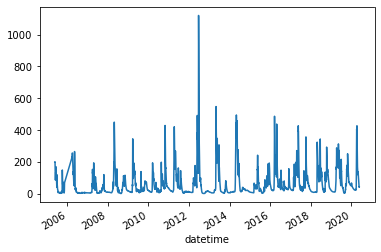

In [9]:
dvs[4021520]['Q'] = pd.to_numeric(dvs[4021520]['72604_00060_00003'], errors='coerce')
ax = dvs[4021520]['Q'].plot()

### get a single site

In [10]:
df = nwis.get_dvs(4015475)
df.head()

http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=04015475&startDT=1880-01-01&parameterCd=00060


,agency_cd,site_no,datetime,72578_00060_00003,72578_00060_00003_cd
datetime,,,,,
1978-09-19,USGS,4015475,1978-09-19,143.0,A
1978-09-20,USGS,4015475,1978-09-20,125.0,A
1978-09-21,USGS,4015475,1978-09-21,100.0,A
1978-09-22,USGS,4015475,1978-09-22,80.0,A
1978-09-23,USGS,4015475,1978-09-23,83.0,A


### just get the url for dvs for a site
(`start_date` is 1880-01-01 by default; `end_date` is `None` by default)

In [11]:
url = nwis.make_dv_url(4015475)
url

http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=04015475&startDT=1880-01-01&parameterCd=00060


'http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=04015475&startDT=1880-01-01&parameterCd=00060'

## Fetch some miscellaneous measurements

In [12]:
sites = field_sites.site_no.tolist()[:5]
sites

[4021520]

In [13]:
fm = nwis.get_all_measurements(sites)

4021520
http://nwis.waterdata.usgs.gov/nwis/measurements?site_no=04021520&agency_cd=USGS&format=rdb


In [14]:
fm.head()

agency_cd  site_no  measurement_nu  \
site_no datetime                                                 
4021520 2005-04-27 12:11:00      USGS  4021520               1   
        2005-05-23 12:20:00      USGS  4021520               2   
        2005-05-26 14:51:00      USGS  4021520               3   
        2005-06-07 14:45:00      USGS  4021520               4   
        2005-07-22 12:50:00      USGS  4021520               5   

                                 measurement_dt tz_cd q_meas_used_fg party_nm  \
site_no datetime                                                                
4021520 2005-04-27 12:11:00 2005-04-27 12:11:00   CDT            Yes  KGG/GRM   
        2005-05-23 12:20:00 2005-05-23 12:20:00   CDT            Yes  GRM/WWL   
        2005-05-26 14:51:00 2005-05-26 14:51:00   CDT            Yes  DLR/GRM   
        2005-06-07 14:45:00 2005-06-07 14:45:00   CDT            Yes      DLR   
        2005-07-22 12:50:00 2005-07-22 12:50:00   CDT            Yes      GRM   

                            site_visit_coll_agency_cd  gage_height_va  \
site_no datetime                                                        
4021520 2005-04-27 12:11:00                      USGS            4.19   
        2005-05-23 12:20:00                      USGS            4.22   
        2005-05-26 14:51:00                      USGS            5.01   
        2005-06-07 14:45:00                      USGS            3.91   
        2005-07-22 12:50:00                      USGS            1.61   

                             discharge_va measured_rating_diff  \
site_no datetime                                                 
4021520 2005-04-27 12:11:00        129.00                 Good   
        2005-05-23 12:20:00        135.00                 Good   
        2005-05-26 14:51:00        199.00                 Good   
        2005-06-07 14:45:00        113.00                 Good   
        2005-07-22 12:50:00          5.82                 Fair   

                             gage_va_change  gage_va_time control_type_cd  \
site_no datetime                                                            
4021520 2005-04-27 12:11:00            0.00           1.1           Clear   
        2005-05-23 12:20:00           -0.01           0.9           Clear   
        2005-05-26 14:51:00            0.02           1.1           Clear   
        2005-06-07 14:45:00            0.00           0.7           Clear   
        2005-07-22 12:50:00            0.00           0.5           Clear   

                            discharge_cd  
site_no datetime                          
4021520 2005-04-27 12:11:00         NONE  
        2005-05-23 12:20:00         NONE  
        2005-05-26 14:51:00         NONE  
        2005-06-07 14:45:00         NONE  
        2005-07-22 12:50:00         NONE

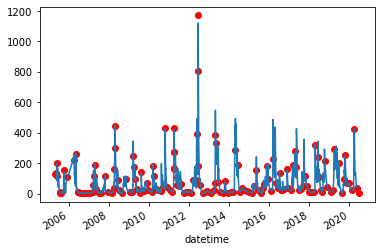

In [15]:
ax = fm.loc[4021520, 'discharge_va'].plot(lw=0, marker='o', color='r')
dvs[4021520]['Q'].plot(ax=ax)